In [1]:
import scanpy as sc
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as stats
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shapely
import glob
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageDraw
import numpy as np
from scipy.spatial import cKDTree
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from core_functions.unrolling import *

## Training model on reference

In [7]:
#Path to replicates folder
data_dir = 'D:/amonell/timecourse_replicates'
#Path to reference dataset
path_adata = 'D:/amonell/timecourse_final/day7_SI_DMSO'

In [3]:
base_topics = np.load(os.path.join(data_dir, 'unrolling_meta', 'base_topicas.npy'))

## Prepare Reference Image

In [5]:
adata = sc.read(os.path.join(data_dir, 'unrolling_meta', 'reference_neighborhoods.h5ad'))
all_spatial = adata.obsm['X_spatial']

try:
    adata.X = adata.X.A
except:
    print('Adata already in array format')
    
topics_contain = base_topics
spatial_points = np.array(adata[adata.obs['topic'].isin(topics_contain), :].obsm['X_spatial'])
other_spatial = np.array(adata[~adata.obs['topic'].isin(topics_contain), :].obsm['X_spatial'])

spatial_points = remove_outliers(spatial_points, 99)

downsize = 10
base_image = create_base_image(spatial_points, other_spatial, downsize = downsize)

file_path = os.path.join(data_dir, 'unrolling_meta', 'roll_image_before_model.png')
base_image.save(file_path)
adata.uns['unrolling_downsize'] = downsize
adata.write(os.path.join(data_dir, 'unrolling_meta', '05_reference_unrolled.h5ad'))

Adata already in array format


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Go to labelme and label the reference image or just use the same longitudinal annotation json as was used in replicate 1 processing

## Parse Reference Image Annotations

In [8]:
base_num_points = 100000
json_file_path = os.path.join(path_adata, 'unrolling', 'roll_image_before_model.json')
removals, points, top_points, mid_points = extract_json_info(json_file_path)
dont_remove, index_set = get_removal_indices(adata, removals, all_spatial)
x_points_bottom, y_points_bottom, x_points_mid, y_points_mid, x_points_top, y_points_top = identify_spiral(adata, points, top_points, mid_points, base_num_points)
all_points, distances_top, indices_top, distances_bottom, indices_bottom, distances_mid, indices_mid = get_distances_and_indices(adata, dont_remove, x_points_bottom, y_points_bottom, x_points_mid, y_points_mid, x_points_top, y_points_top, base_num_points)

  0%|          | 0/225671 [00:00<?, ?it/s]

  0%|          | 0/225671 [00:00<?, ?it/s]

## Get Ready to train neural network

##### Prepare Training Inputs

In [9]:
topic_presorted = sc.read(os.path.join(data_dir, 'unrolling_meta', 'reference_neighborhoods.h5ad')).obs['topic'].values[dont_remove]
model_input = np.array([stats.zscore(distances_top), stats.zscore(distances_mid), stats.zscore(distances_bottom), indices_top, indices_mid, indices_bottom])

##### Prepare Training Outputs

In [16]:
adata = sc.read(os.path.join(path_adata, 'adatas', '05_reference_unrolled.h5ad'))

In [18]:
axis = adata.obs['longitudinal'].values[dont_remove]

##### Define and fit model

In [19]:
num_continuous_features = np.shape(model_input)[0]  # Number of continuous features
unique_categories = np.unique(topic_presorted)
embedding_dim = 3  # Dimensionality of the embedding space
batch_size = 32
num_epochs = 10

# Categorical data as a 1D array
categorical_data = topic_presorted

# One-hot encode the categorical data
encoder = OneHotEncoder(sparse=False)
categorical_data_encoded = encoder.fit_transform(categorical_data.reshape(-1, 1))

# Define input for continuous data
continuous_input = Input(shape=(num_continuous_features,), name='continuous_input')

# Define input for one-hot encoded categorical data
categorical_input = Input(shape=(categorical_data_encoded.shape[1],), name='categorical_input')

# Concatenate the continuous and categorical inputs
concatenated_inputs = Concatenate()([continuous_input, categorical_input])

# Build the neural network architecture
x = Dense(64, activation='relu')(concatenated_inputs)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear', name='output')(x)

# Create the model
model = Model(inputs=[continuous_input, categorical_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use an appropriate loss function for your task

continuous_data = model_input.T
target_values = axis

# Train the model
model.fit(
    {'continuous_input': continuous_data, 'categorical_input': categorical_data_encoded},
    y=target_values,
    batch_size=batch_size,
    epochs=num_epochs
)



C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
7053/7053 [==============================] - 11s 1ms/step - loss: 550015680.0000
Epoch 2/10
7053/7053 [==============================] - 14s 2ms/step - loss: 11935944.0000
Epoch 3/10
7053/7053 [==============================] - 14s 2ms/step - loss: 7221528.0000
Epoch 4/10
7053/7053 [==============================] - 8s 1ms/step - loss: 5225421.5000
Epoch 5/10
7053/7053 [==============================] - 8s 1ms/step - loss: 4609909.0000
Epoch 6/10
7053/7053 [==============================] - 9s 1ms/step - loss: 4372636.0000
Epoch 7/10
7053/7053 [==============================] - 8s 1ms/step - loss: 4161024.7500
Epoch 8/10
7053/7053 [==============================] - 11s 2ms/step - loss: 3990555.0000
Epoch 9/10
7053/7053 [==============================] - 10s 1ms/step - loss: 3835228.5000
Epoch 10/10
7053/7053 [==============================] - 10s 1ms/step - loss: 3649960.0000


##### Use model for prediction

In [20]:
# Use the model for prediction on new data
new_continuous_data = continuous_data
new_categorical_data_encoded = categorical_data_encoded
#predictions = model.predict({'continuous_input': new_continuous_data, 'categorical_input': new_categorical_data_encoded})
predictions = model.predict({'continuous_input': new_continuous_data, 'categorical_input': new_categorical_data_encoded})
adata.obs['predicted_longitudinal'] = predictions


7053/7053 [==============================] - 11s 2ms/step


##### Visualize predictions

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


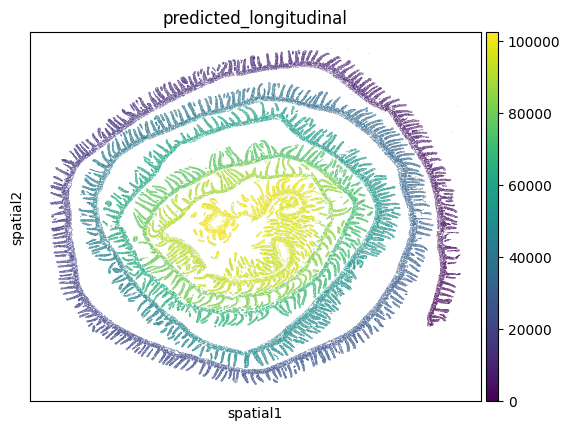

In [21]:
sc.pl.embedding(adata, basis = 'spatial', color='predicted_longitudinal')

# Unrolling the rest of the swiss rolls

Put in the path to the experiment folder

In [22]:
data_dir = 'D:/amonell/timecourse_replicates'
input_folders = glob.glob(os.path.join(data_dir, 'day*'))

In [23]:
for path_adata in input_folders:
    adata = sc.read(os.path.join(path_adata, 'adatas', '04_part2_reference_neighborhoods.h5ad'))
    all_spatial = adata.obsm['X_spatial']

    try:
        adata.X = adata.X.A
    except:
        print('Adata already in array format')
        
    topics_contain = base_topics
    spatial_points = np.array(adata[adata.obs['topic'].isin(topics_contain), :].obsm['X_spatial'])
    other_spatial = np.array(adata[~adata.obs['topic'].isin(topics_contain), :].obsm['X_spatial'])

    spatial_points = remove_outliers(spatial_points, 99)

    downsize = 10
    base_image = create_base_image(spatial_points, other_spatial, downsize = downsize)

    try:
        os.mkdir(os.path.join(path_adata,'unrolling'))
    except:
        print('unrolling directory already exists')
    file_path = os.path.join(path_adata, 'unrolling', 'roll_image.png')
    base_image.save(file_path)
    adata.uns['unrolling_downsize'] = downsize
    adata.write(os.path.join(path_adata, 'adatas', '04_part2_reference_neighborhoods.h5ad'))

Adata already in array format


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Adata already in array format


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Adata already in array format


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Adata already in array format


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Go to labelme (pip install labelme > labelme) > open > open roll_image.png > create polygons > make polygons and save

  0%|          | 0/258269 [00:00<?, ?it/s]

  0%|          | 0/258269 [00:00<?, ?it/s]

8071/8071 [==============================] - 13s 2ms/step


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


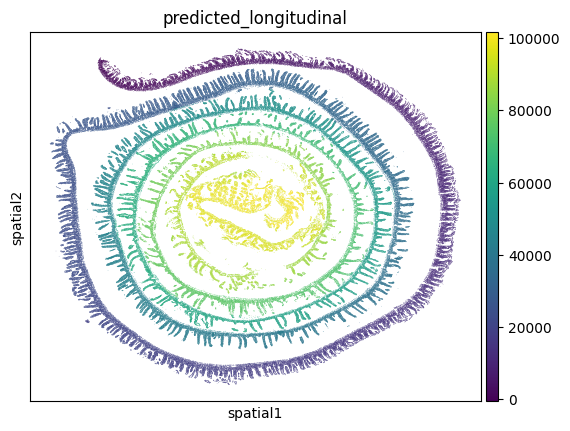

  0%|          | 0/274464 [00:00<?, ?it/s]

  0%|          | 0/274464 [00:00<?, ?it/s]

  0%|          | 0/274464 [00:00<?, ?it/s]

  0%|          | 0/268986 [00:00<?, ?it/s]

8406/8406 [==============================] - 13s 1ms/step


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


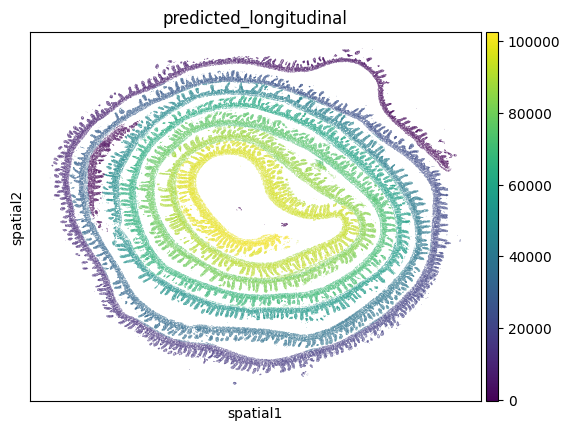

  0%|          | 0/198887 [00:00<?, ?it/s]

  0%|          | 0/198887 [00:00<?, ?it/s]

  0%|          | 0/198806 [00:00<?, ?it/s]

6213/6213 [==============================] - 7s 1ms/step


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


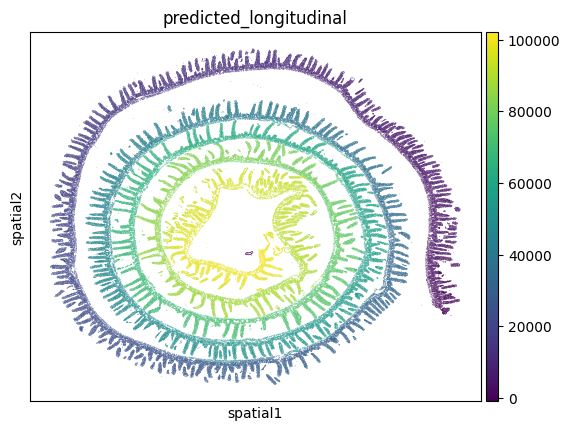

  0%|          | 0/241781 [00:00<?, ?it/s]

  0%|          | 0/241781 [00:00<?, ?it/s]

  0%|          | 0/240727 [00:00<?, ?it/s]

7523/7523 [==============================] - 5s 725us/step


C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


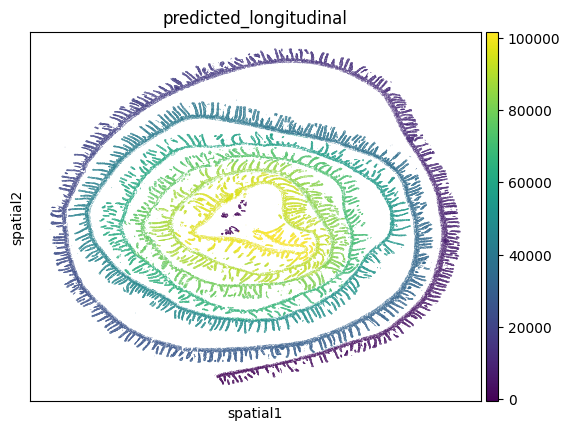

In [28]:
for path_adata in input_folders:
    adata = sc.read(os.path.join(path_adata, 'adatas', '04_part2_reference_neighborhoods.h5ad'))
    all_spatial = adata.obsm['X_spatial']

    json_file_path = os.path.join(path_adata, 'unrolling', 'roll_image.json')
    
    base_num_points = 100000
    removals, points, top_points, mid_points = extract_json_info(json_file_path)
    dont_remove, index_set = get_removal_indices(adata, removals, all_spatial)
    x_points_bottom, y_points_bottom, x_points_mid, y_points_mid, x_points_top, y_points_top = identify_spiral(adata, points, top_points, mid_points, base_num_points)
    all_points, distances_top, indices_top, distances_bottom, indices_bottom, distances_mid, indices_mid = get_distances_and_indices(adata, dont_remove, x_points_bottom, y_points_bottom, x_points_mid, y_points_mid, x_points_top, y_points_top, base_num_points)

    topic_presorted = adata.obs['topic'].values[dont_remove]
    model_input = np.array([stats.zscore(distances_top), stats.zscore(distances_mid), stats.zscore(distances_bottom), indices_top, indices_mid, indices_bottom])

    # Categorical data as a 1D array
    categorical_data = topic_presorted
    
    categorical_data_encoded = encoder.transform(categorical_data.reshape(-1, 1))
    
    continuous_data = model_input.T

    predictions = model.predict({'continuous_input': continuous_data, 'categorical_input': categorical_data_encoded})

    new_longitidunal = np.zeros(len(adata.obs.index))
    new_longitidunal[dont_remove] = predictions.flatten()
    new_longitidunal[list(index_set)] = -1
    adata.obs['predicted_longitudinal'] = new_longitidunal
    sc.pl.embedding(adata, basis='spatial', color='predicted_longitudinal')
    
    adata.obs['not_removed_from_longitudinal'] = new_longitidunal != -1
    adata.write(os.path.join(path_adata, 'adatas', '05_unrolled.h5ad'))

## Plot Predictions

C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\amonell\anaconda3_2\envs\tensorflow\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and 

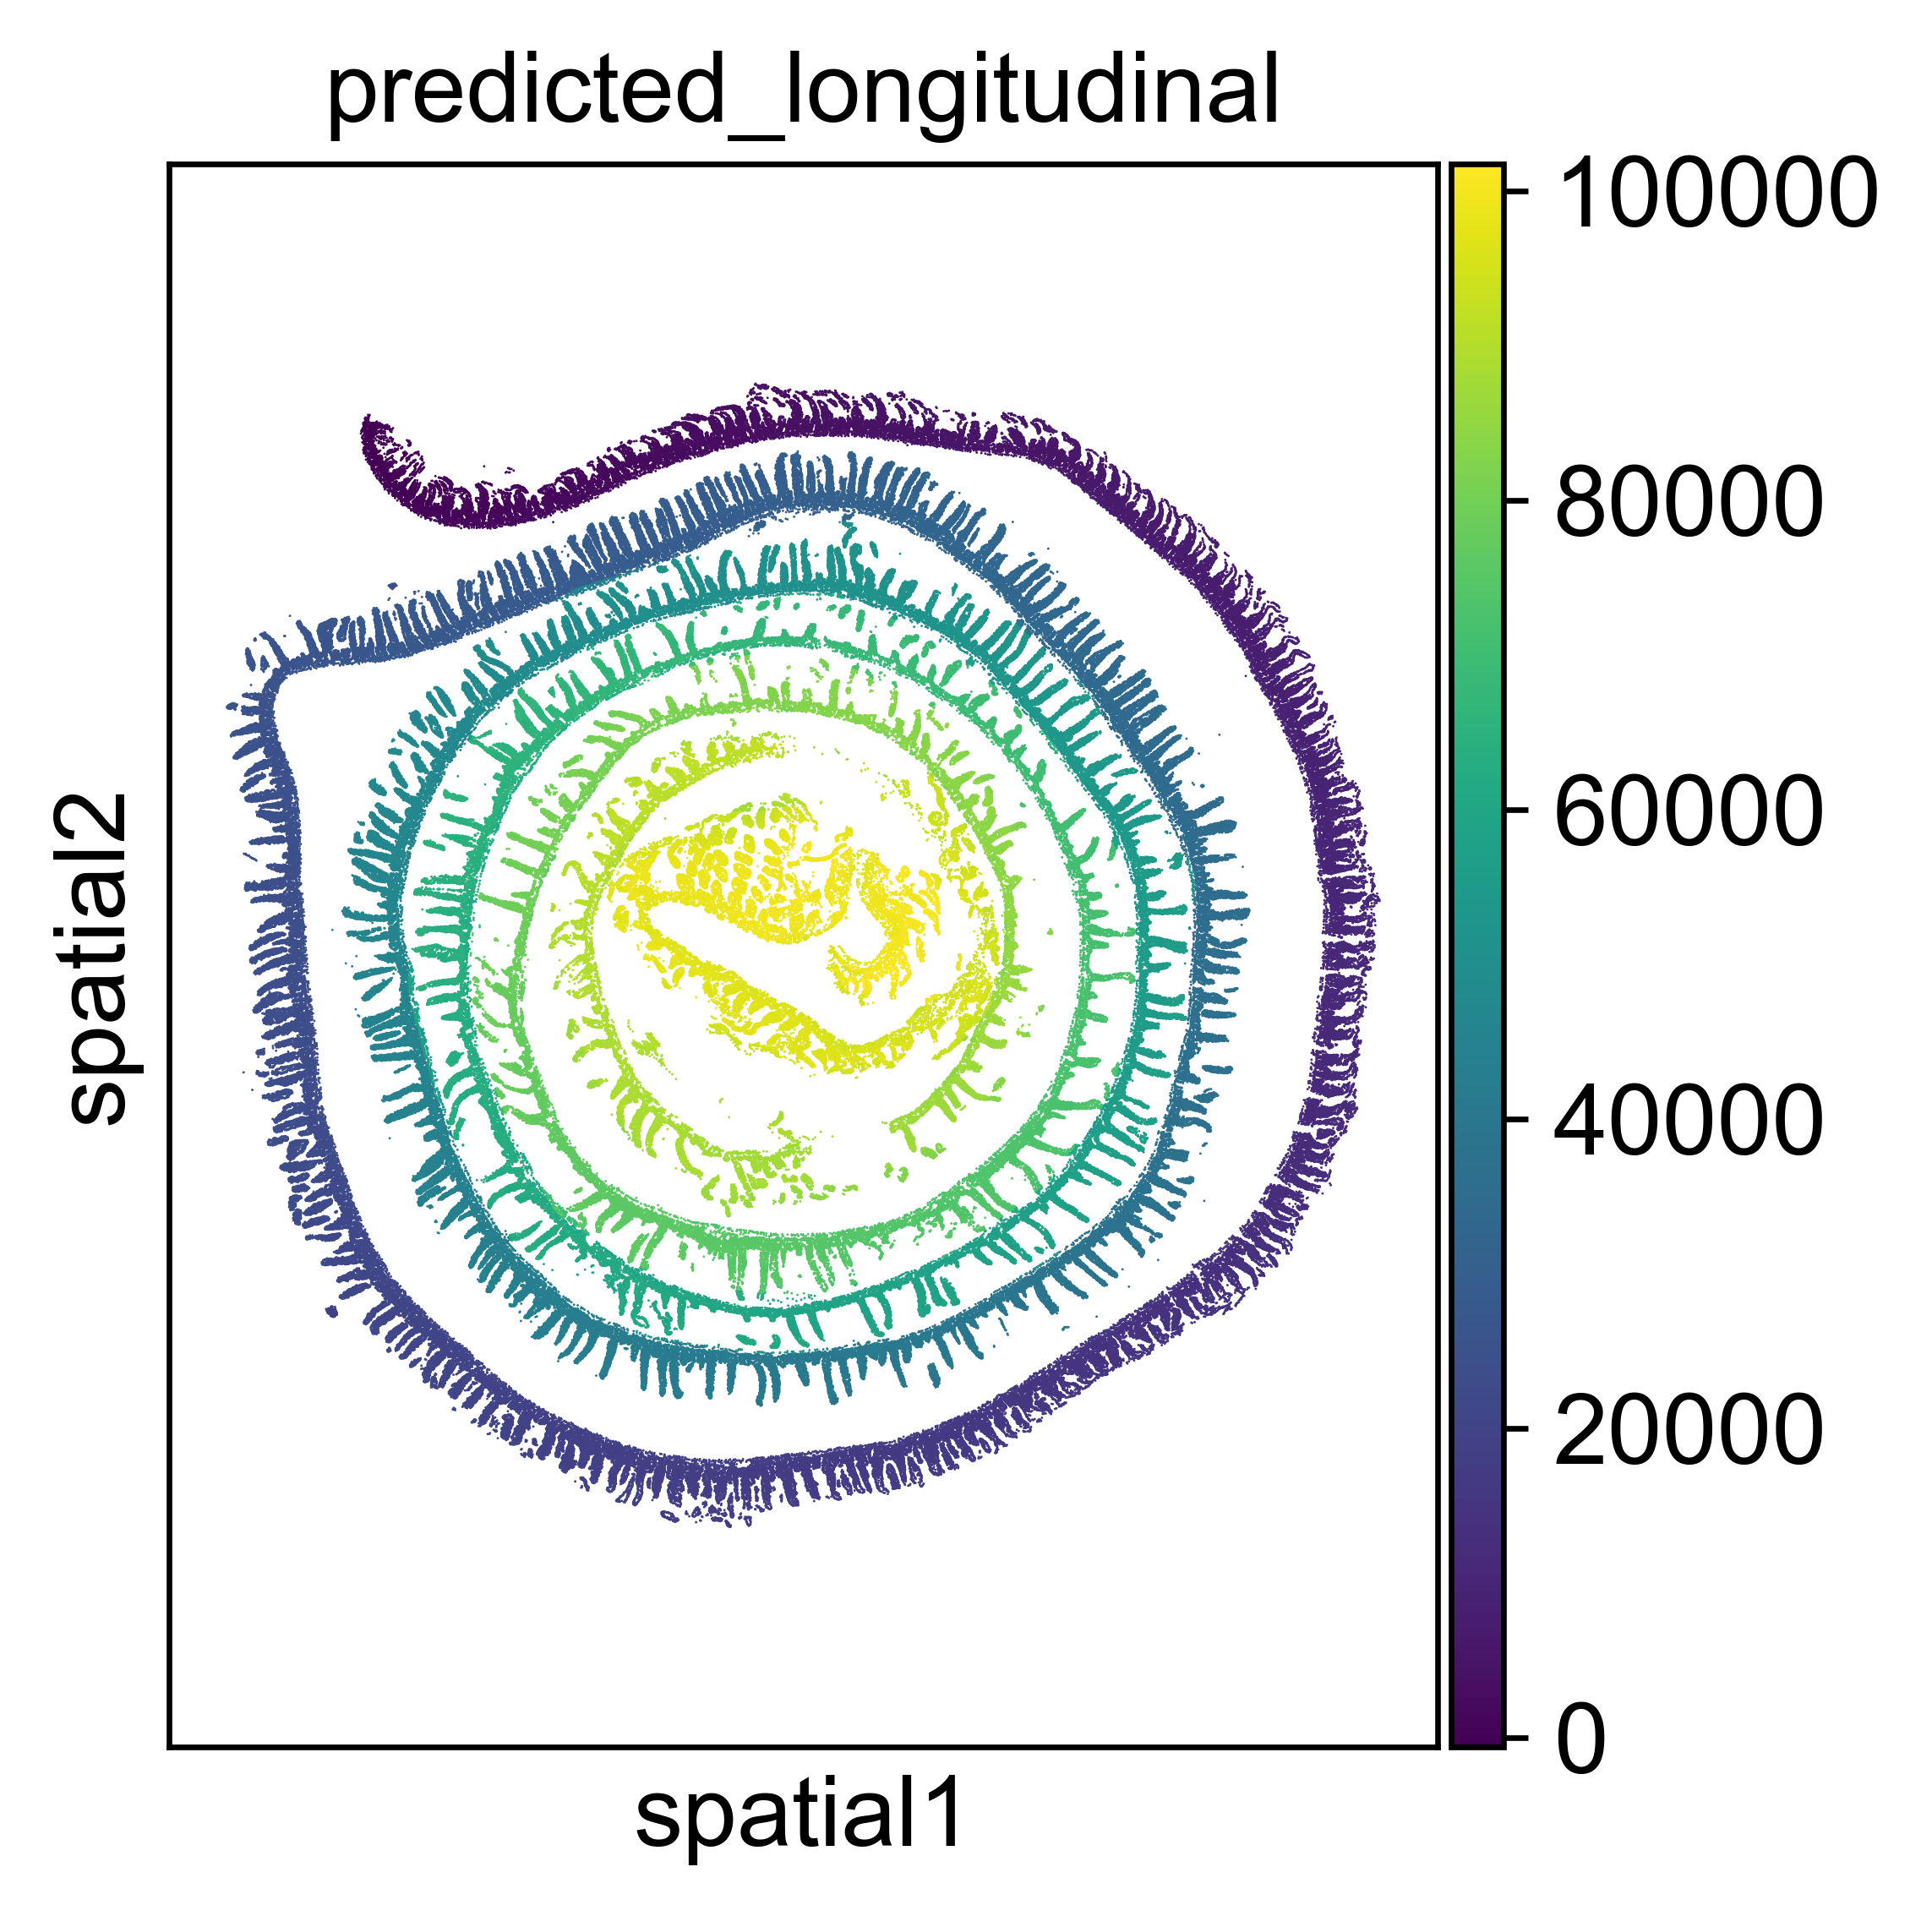

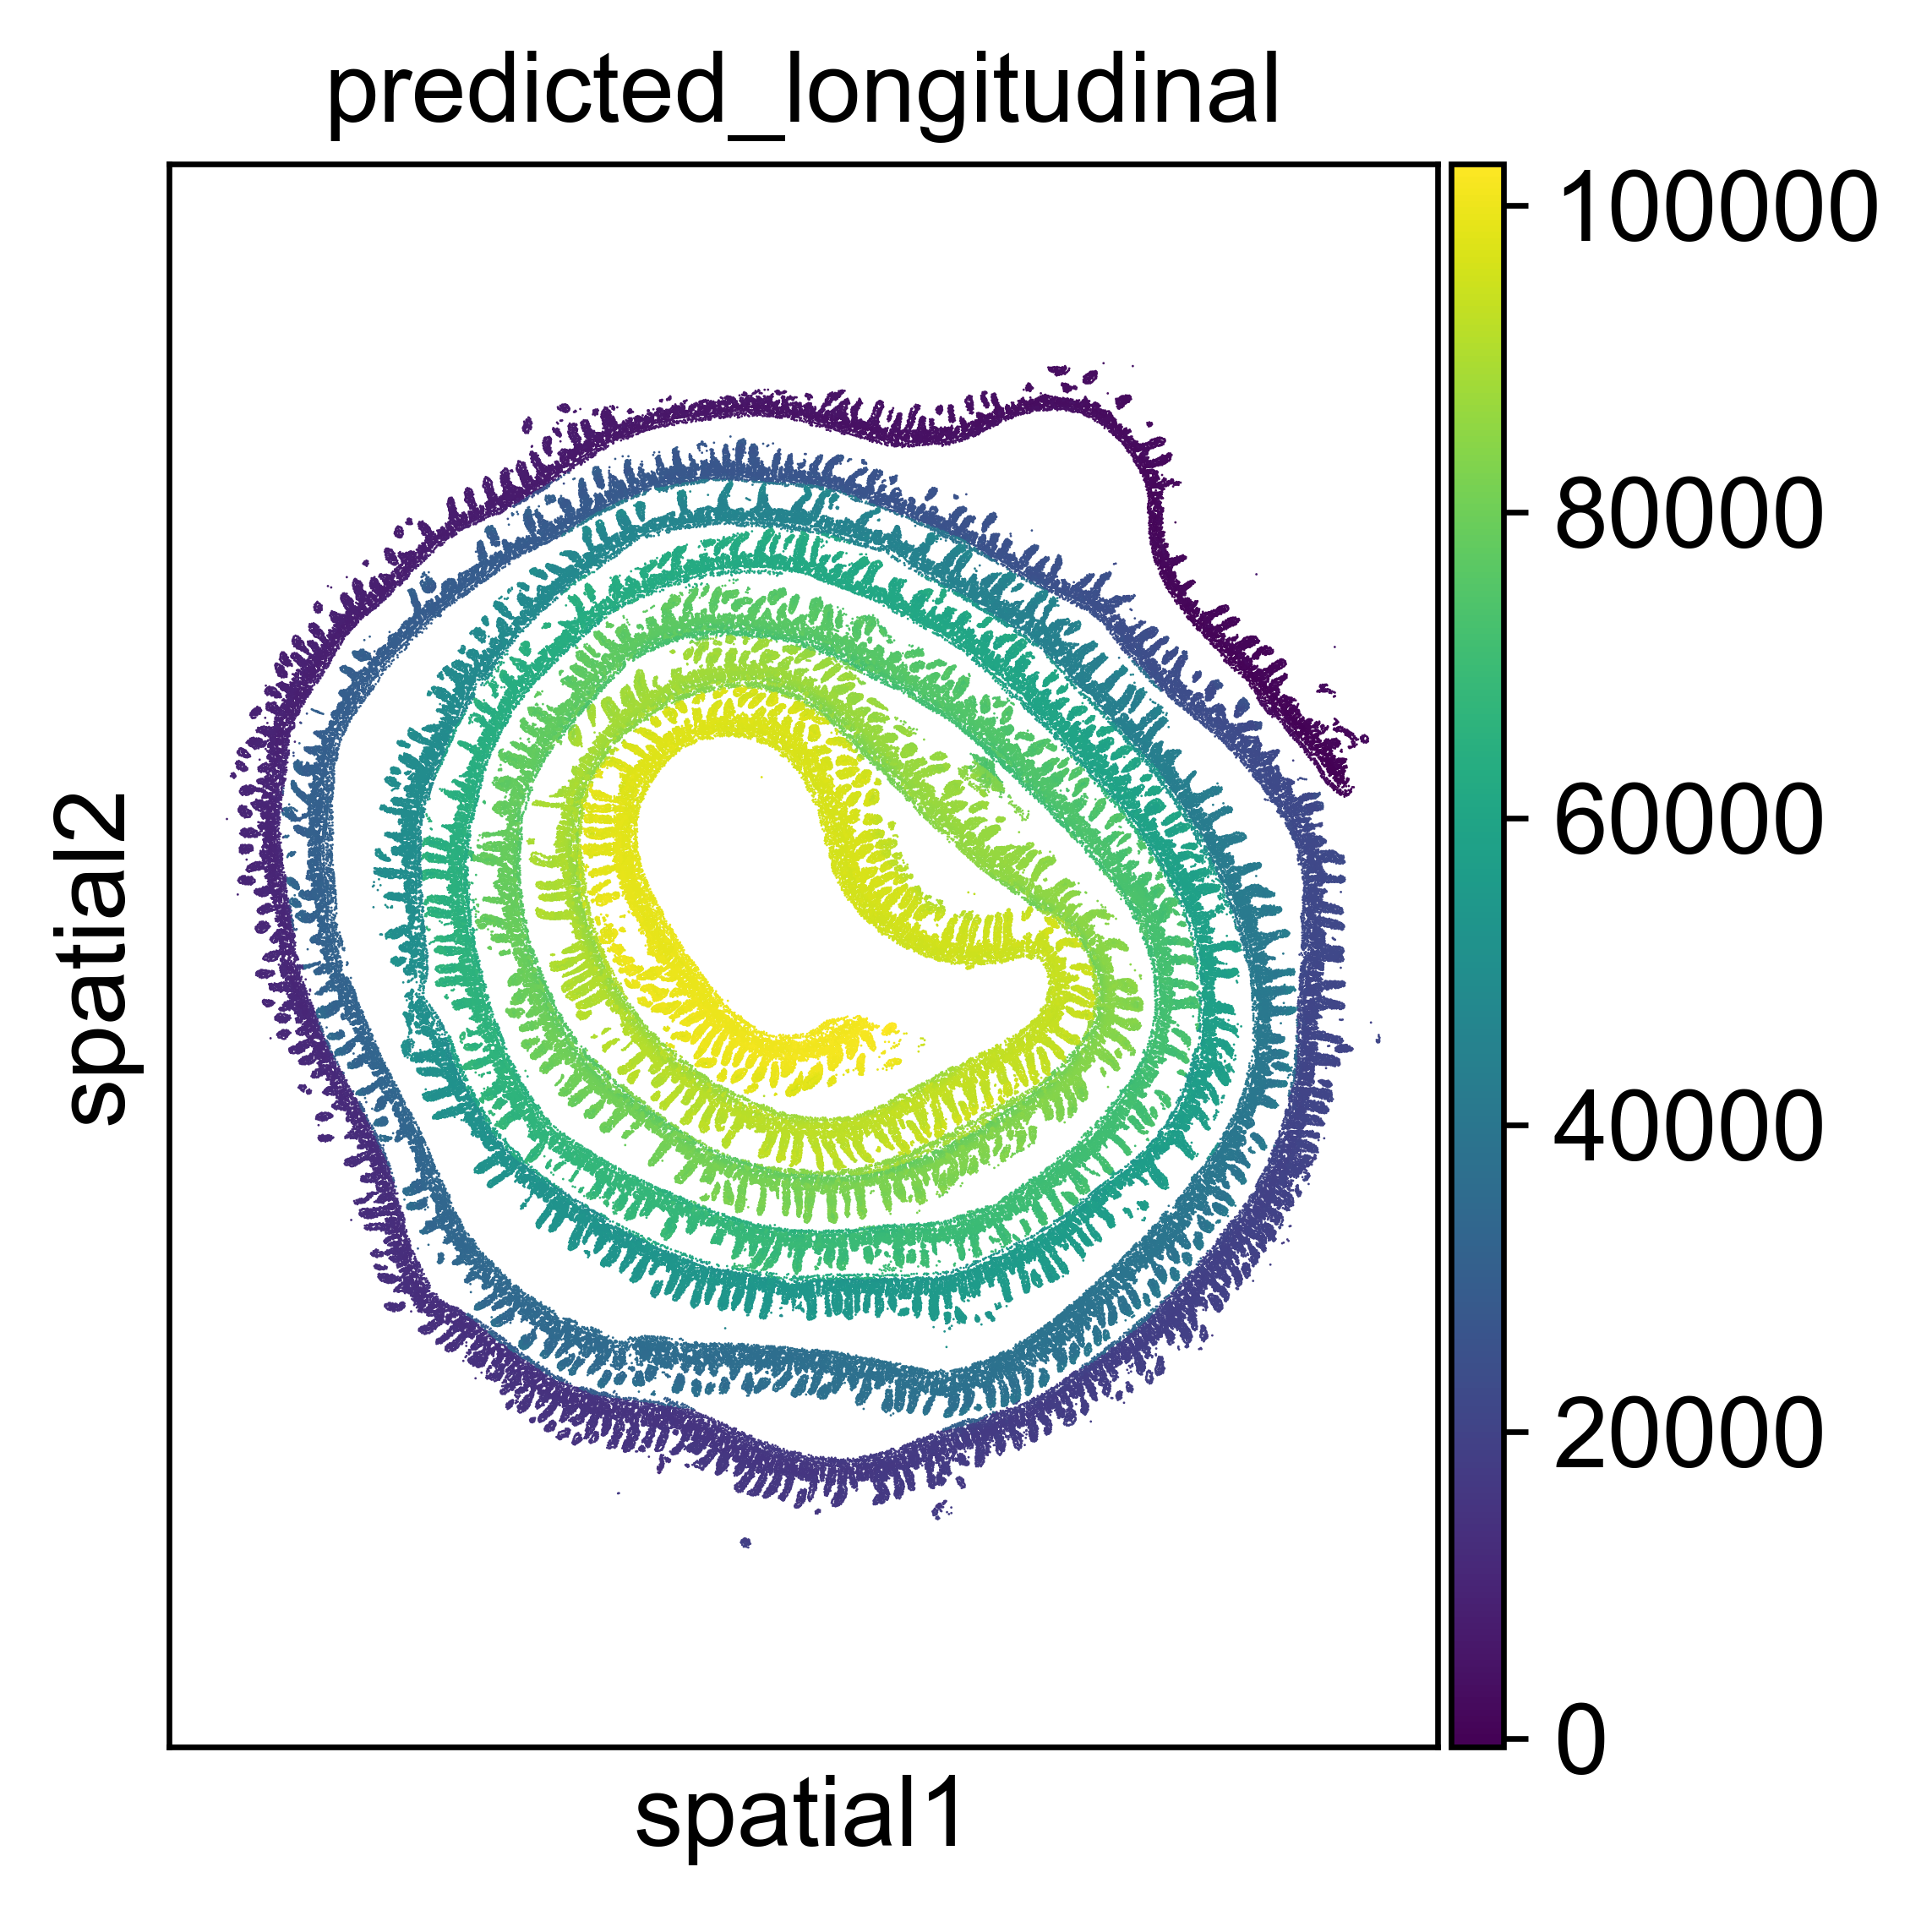

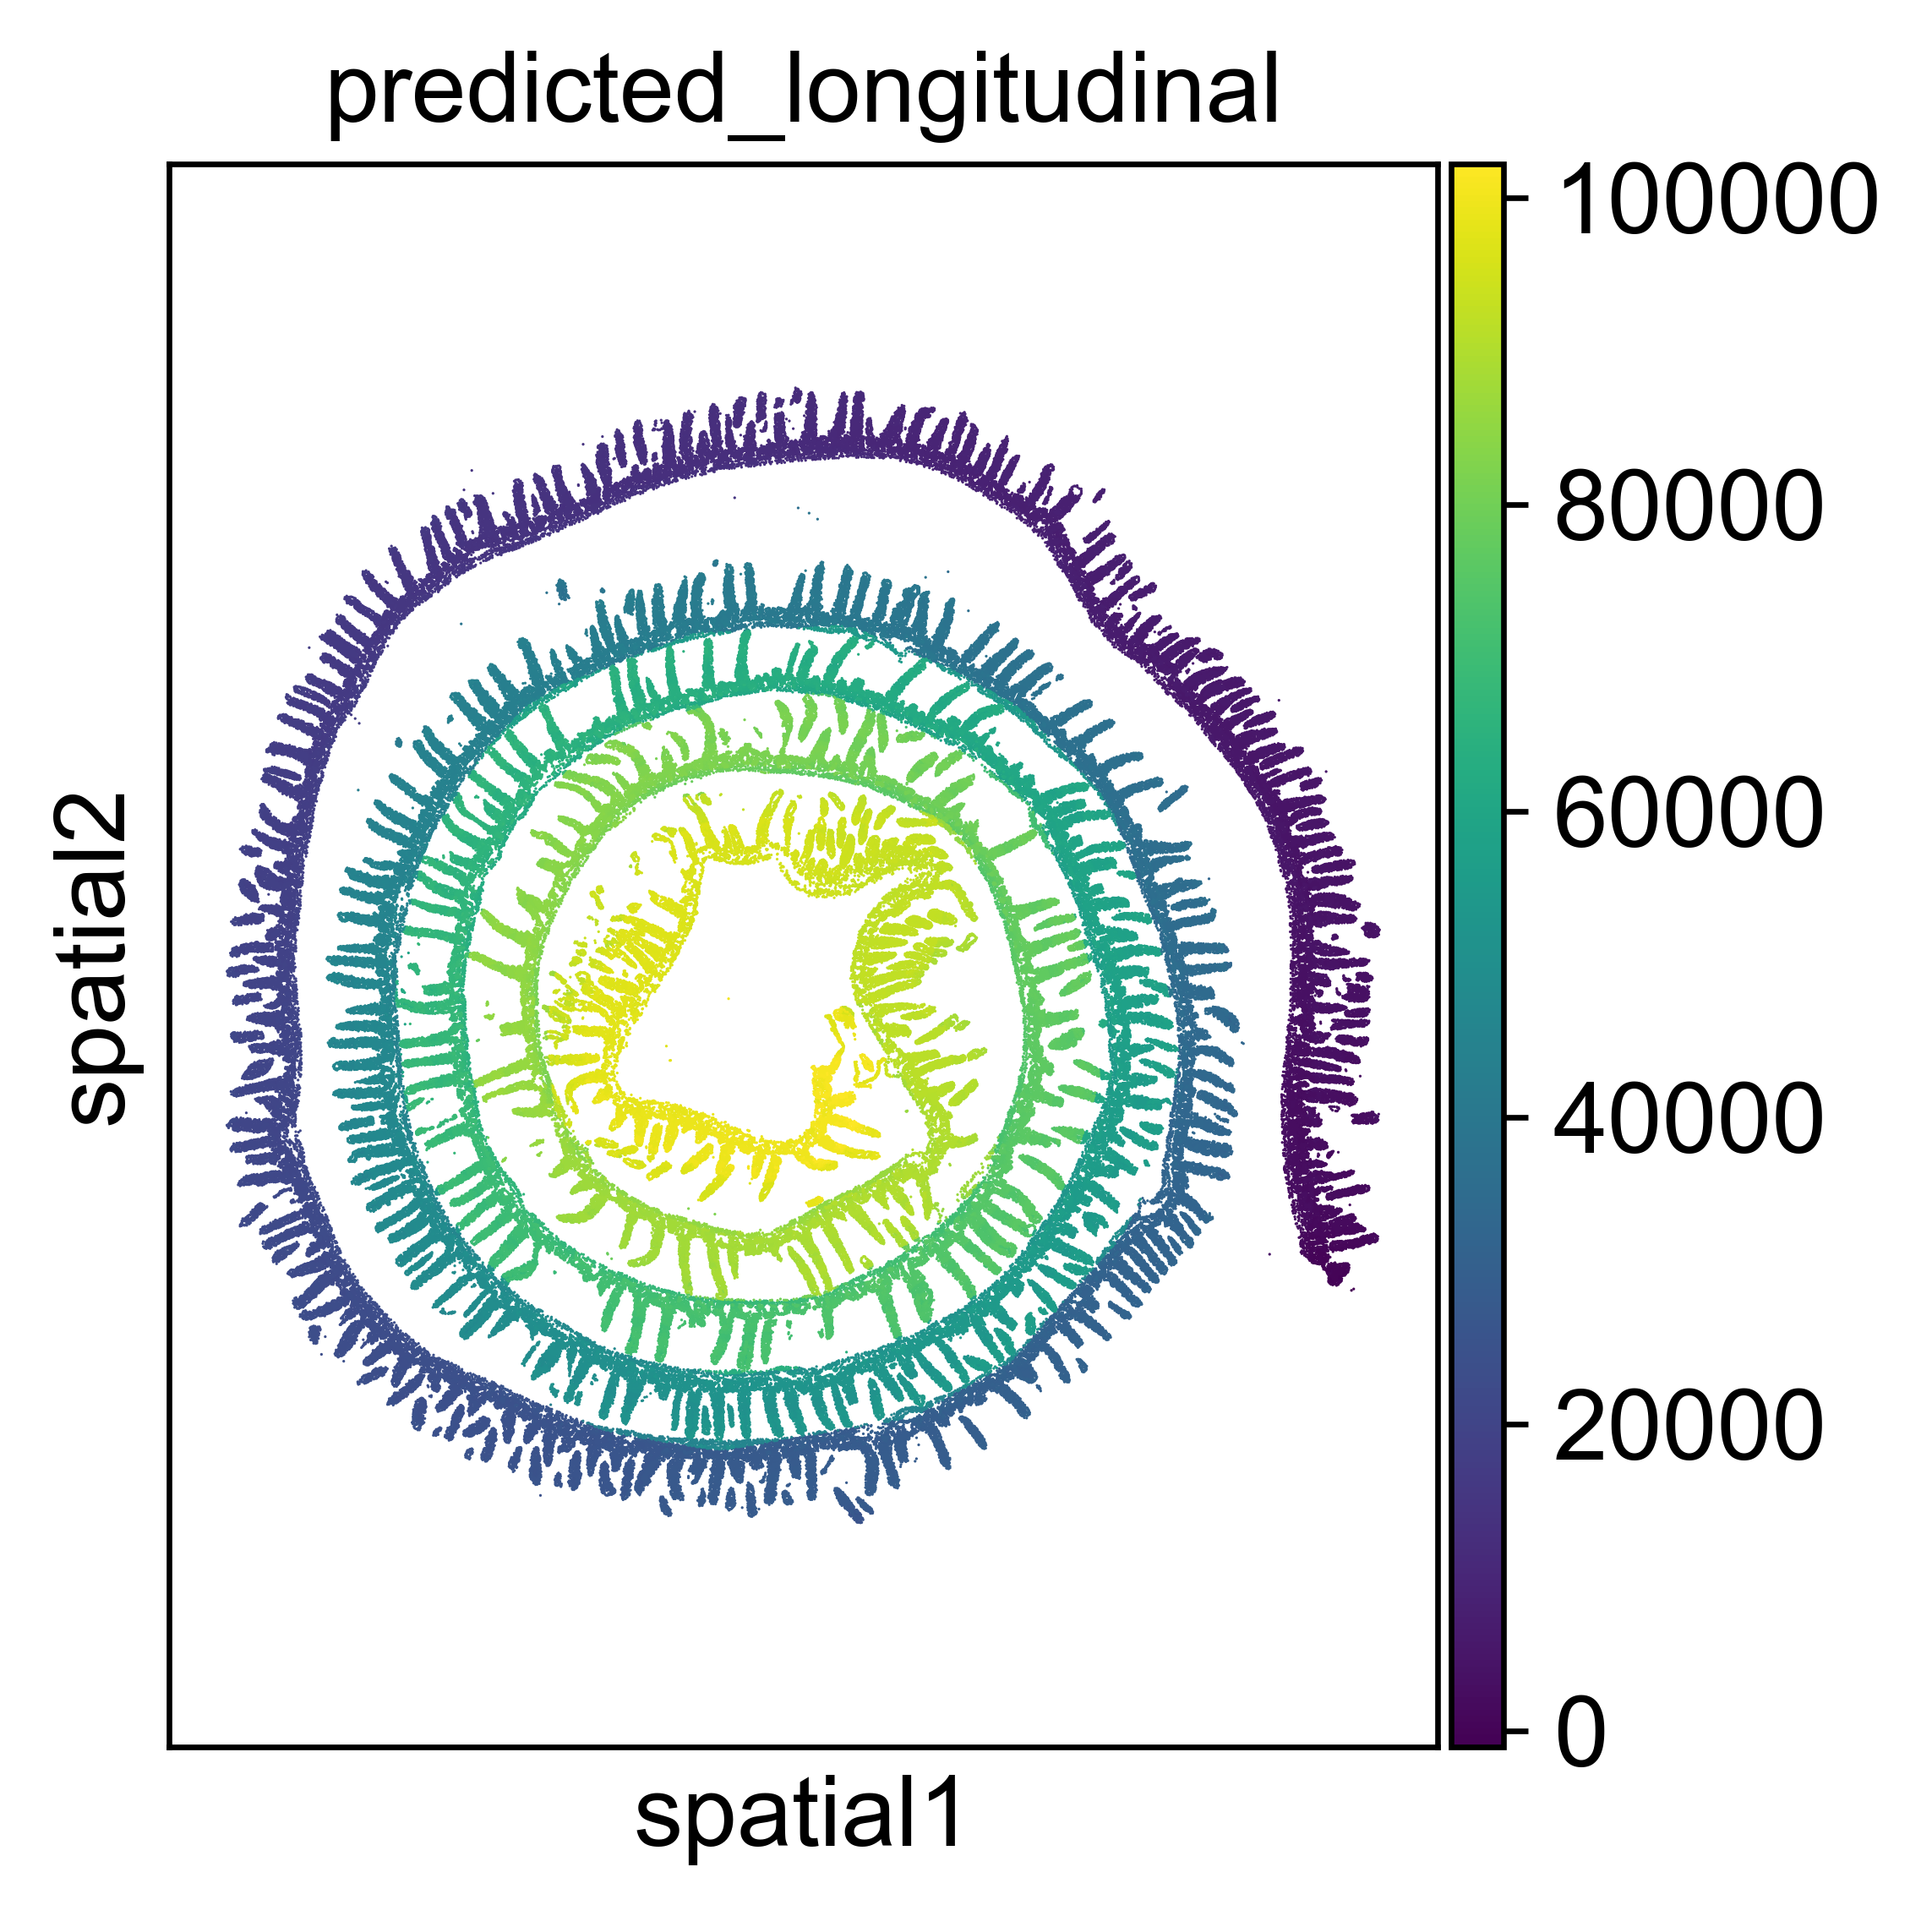

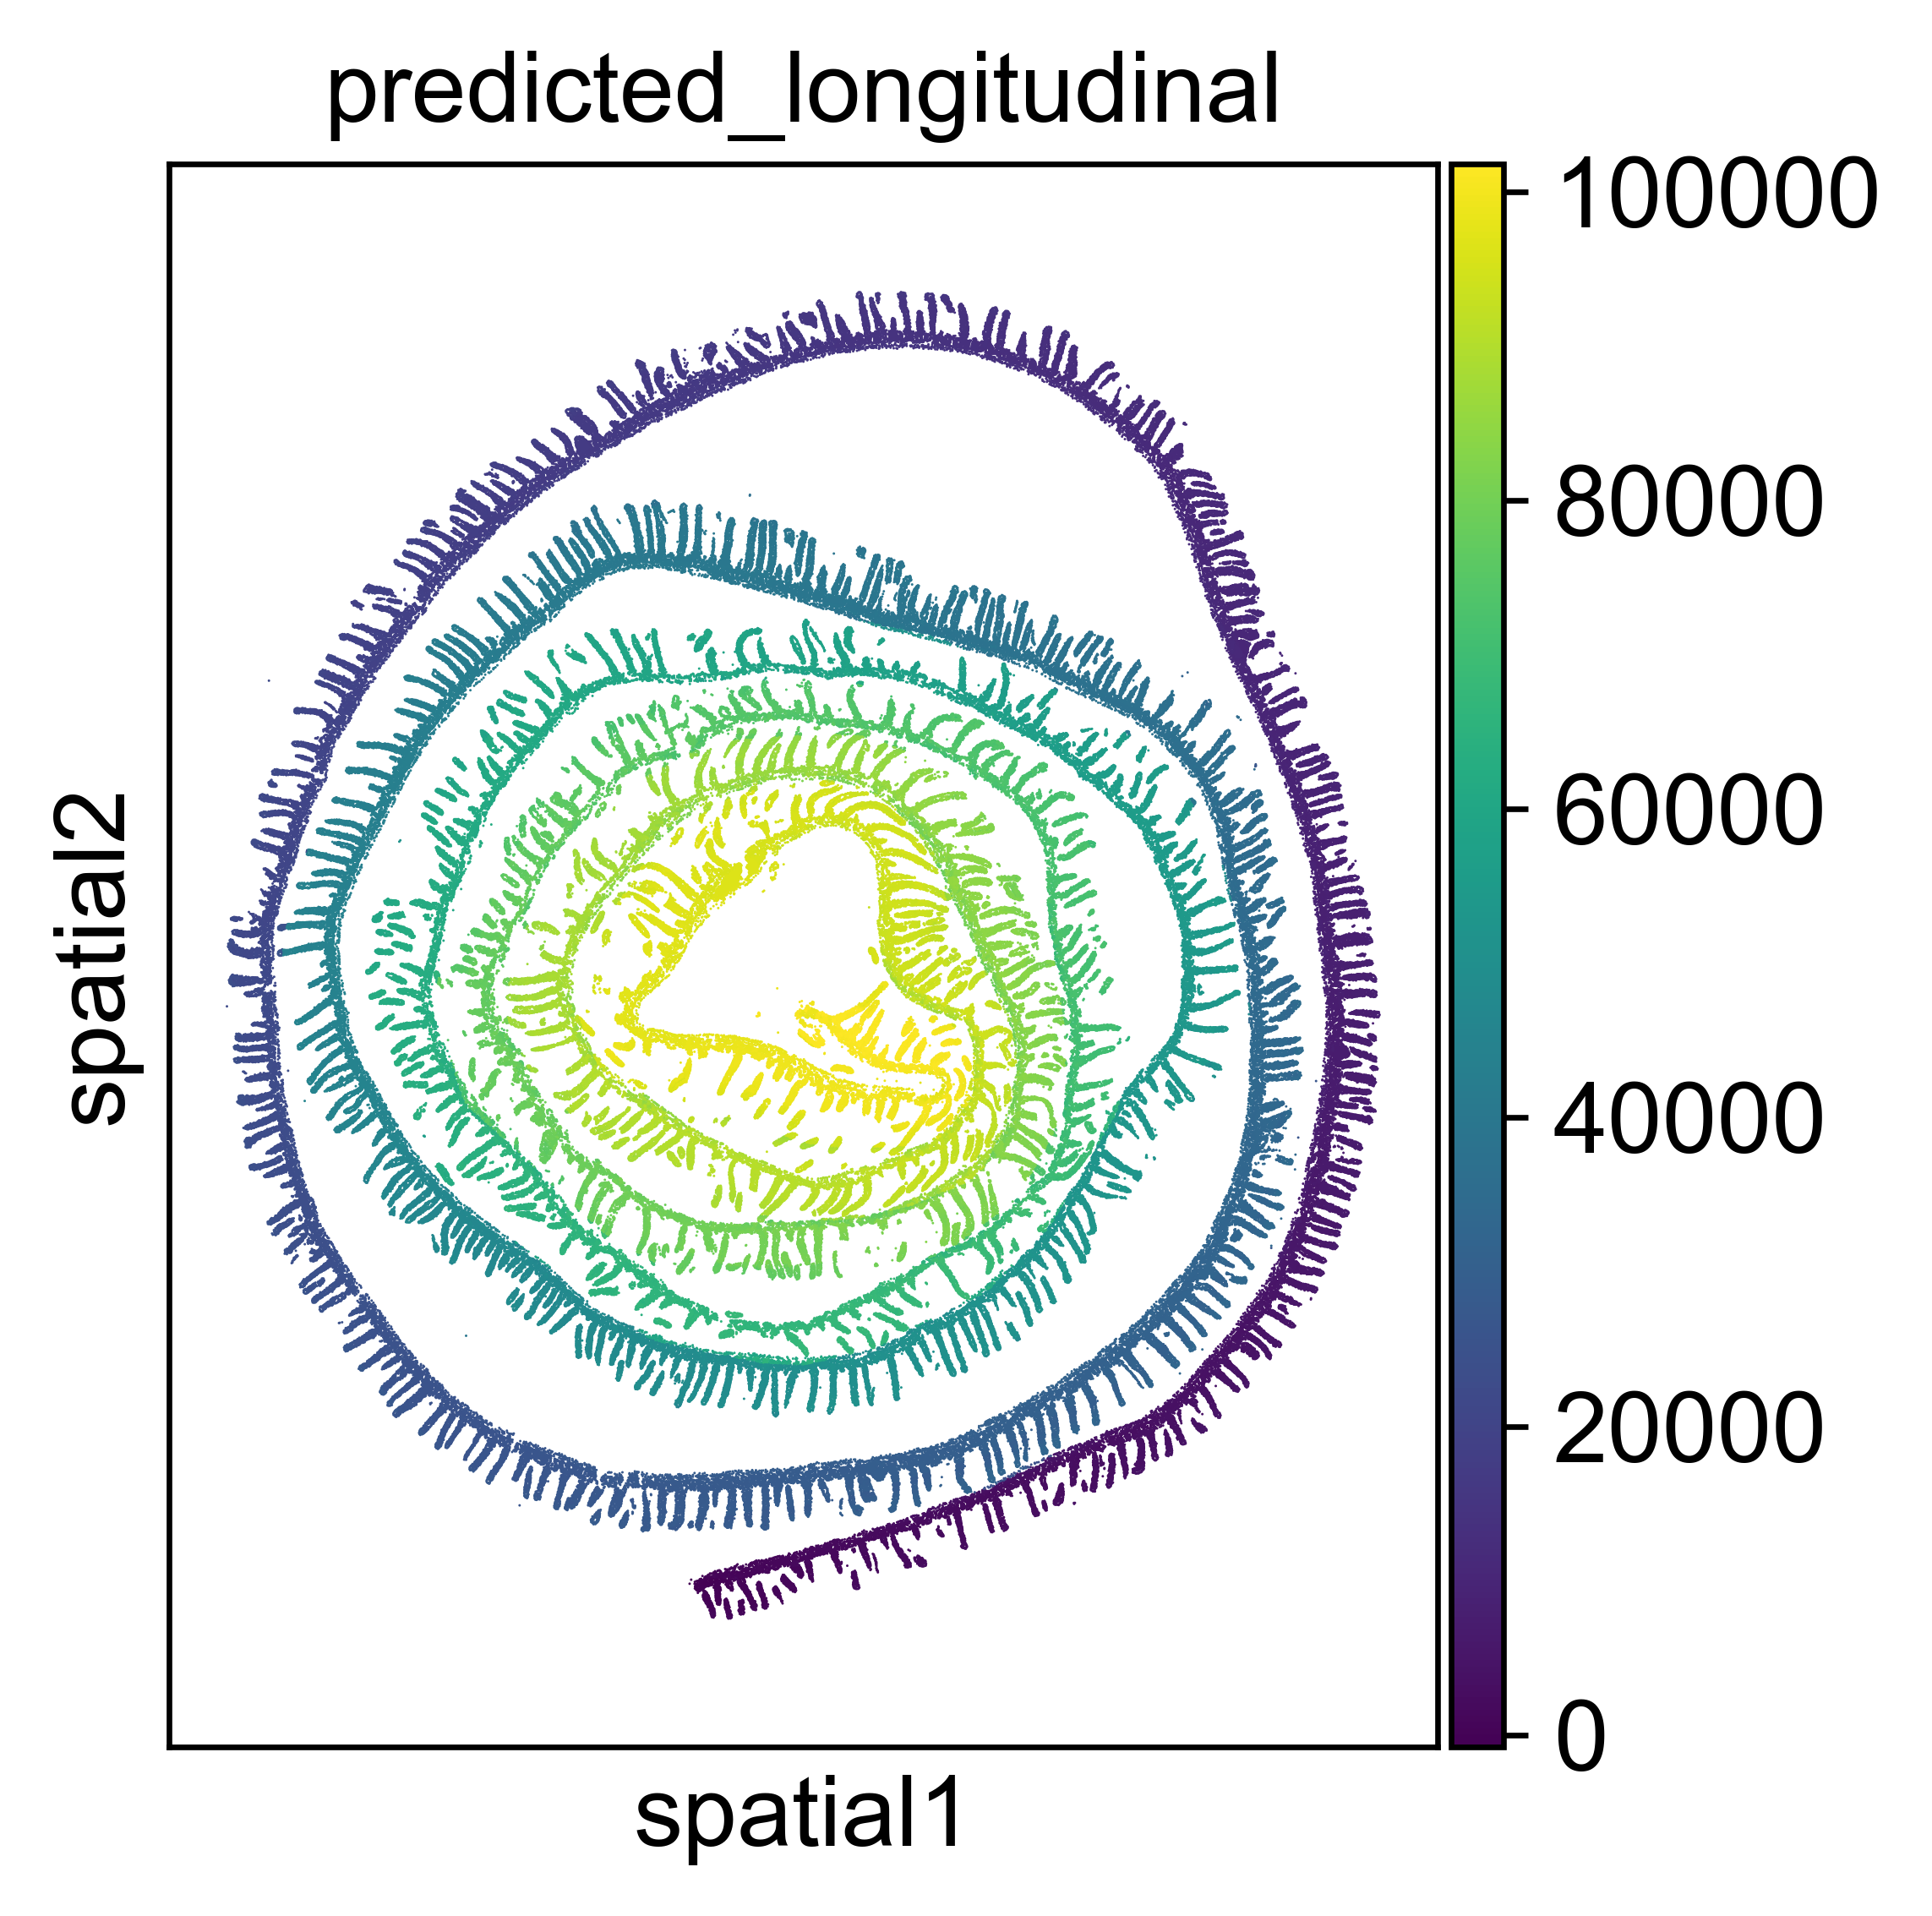

In [29]:
sc.set_figure_params(dpi=300)
for path_adata in input_folders:
    adata = sc.read(os.path.join(path_adata, 'adatas', '05_unrolled.h5ad'))
    fig = sc.pl.embedding(adata[adata.obs['not_removed_from_longitudinal'], :], basis = 'spatial', color='predicted_longitudinal', return_fig=True, show=False)
    try:
        os.mkdir(os.path.join(path_adata, 'figures', 'axes'))
    except:
        print('axes directory already exists')
    fig.tight_layout()
    plt.axis('equal')
    fig.savefig(os.path.join(path_adata, 'figures', 'axes', 'spatial_longitudinal.png'))